# Regression

###### COMP4670/8600 - Introduction to Statistical Machine Learning - Week 2

In this lab, we will use linear regression to predict the value of a home and explore the impact of regularisation.

### Assumed knowledge
- Maximum likelihood solution to a linear regression problem, with and without regularisation (week 2 lectures)
- Matrix calculations in numpy (week 1 lab and precourse material)
- Theory behind regularisation (week 2 lectures)

### After this lab, you should be comfortable with:
- Practical linear regression problems
- Picking an appropriate regularisation parameter for a given problem

$\newcommand{\trace}[1]{\operatorname{tr}\left\{#1\right\}}$
$\newcommand{\Norm}[1]{\lVert#1\rVert}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\inner}[2]{\langle #1, #2 \rangle}$
$\newcommand{\DD}{\mathscr{D}}$
$\newcommand{\grad}[1]{\operatorname{grad}#1}$
$\DeclareMathOperator*{\argmin}{arg\,min}$

Setting up the environment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv

%matplotlib inline

## The data set


We will use [a dataset](https://machlearn.gitlab.io/sml2019/tutorials/02-dataset.csv) on the price of housing in Boston (see [description](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)). 
We aim to predict the value of a home from other factors.
In this dataset, each row is one house. The first entry is the value of the house, which has been normalised to be in the range $[-1, 1]$, and we will predict of the remaining values. The column labels are

```'medv', 'crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat'```

Download the dataset. Read in the data using ```np.loadtxt``` with the optional argument ```delimiter=','```, as our data is comma separated rather than space separated. Remove the column containing the binary variable ```'chas'```.

In [2]:
dataset = np.loadtxt("02-dataset.csv", delimiter=',')

# remove 'chas' feature from dataset
d = np.empty(shape=(dataset.shape[0], dataset.shape[1]-1))
d[:, :4] = dataset[:, :4]
d[:, 4:] = dataset[:, 5:]
dataset = d

# normalize target variables
norm_target = np.reshape(dataset[:, 0], (dataset.shape[0], 1))
target_min = min(norm_target)
target_max = max(norm_target)
norm_target = (norm_target - (target_min*np.ones(norm_target.shape))) / (target_max-target_min)
dataset[:,0] = np.reshape(norm_target, (dataset.shape[0], ))

print(norm_target.shape)
print(dataset[:,0].shape)

(506, 1)
(506,)


### Note

Normalization formula:
\begin{equation*}
    \frac{\text{initial value} - \text{min value}}{\text{max value} - \text{min value}}
\end{equation*}


Check that the data is as expected using ```print()```. It should have 506 rows (examples) and 13 columns (1 label and 12 features). Check that this is the case. 

Hint: use  assert.

In [3]:
print("dataset matrix shape:",dataset.shape)
print(dataset)

dataset matrix shape: (506, 13)
[[ 0.42222222 -1.         -0.64       ... -0.425532    1.
  -0.82064   ]
 [ 0.35555556 -0.999528   -1.         ...  0.106383    1.
  -0.59106   ]
 [ 0.64444444 -0.999529   -1.         ...  0.106383    0.979475
  -0.873068  ]
 ...
 [ 0.4        -0.998776   -1.         ...  0.787234    1.
  -0.784216  ]
 [ 0.37777778 -0.997679   -1.         ...  0.787234    0.982601
  -0.737859  ]
 [ 0.13333333 -0.999076   -1.         ...  0.787234    1.
  -0.660596  ]]


## Regression without regularisation

Implement a function to find the maximum likelihood solution $w_{ML}$ assuming Gaussian noise for this linear regression problem. Remember from the lectures that this is equivalent to a linear regresion problem with the cost function set as the sum of squares error.

In [4]:
"""
X is feature matrix (n*d)
t is target examples (d*1)
"""
def maxLikelihood(X, t):
    # add a bias column to feature matrix (i.e column of 1s)
    Xb = np.ones((X.shape[0], X.shape[1]+1))
    Xb[:, 1:] = X
    X = Xb
    return inv(X.T@X)@X.T@t

def RMSError(X, t, w):
    # add a bias column to feature matrix (i.e column of 1s)
    Xb = np.ones((X.shape[0], X.shape[1]+1))
    Xb[:, 1:] = X
    X = Xb
    return np.sqrt( (1/(X.shape[0])) * (X@w -t)@(X@w -t) )

def regFunction(X,w):
    # add a bias column to feature matrix (i.e column of 1s)
    Xb = np.ones((X.shape[0], X.shape[1]+1))
    Xb[:, 1:] = X
    X = Xb
    return X@w

## Training and testing

Use a fifth of the available data for training the model using maximum likelihood. The rest of the data is allocated to the test set. Report the root mean squared error (RMSE) for the training set and the test set.

Note that the data may be sorted or ordered in some way we cannot predict. How will you account for this?

In [5]:
np.random.shuffle(dataset) #randomize row order of dataset matrix

trainset_size = 2/5
row_cut = int(dataset.shape[0] * trainset_size)

trainset = dataset[:row_cut, :]
testset = dataset[row_cut:, :]
print(trainset.shape)
print(testset.shape)

train_feature = trainset[:,1:]
train_target = trainset[:,0]
print(train_feature.shape)
print(train_target.shape)

test_feature = testset[:, 1:]
test_target = testset[:, 0]

(202, 13)
(304, 13)
(202, 12)
(202,)


## Interpreting the model

Find the feature with the biggest weight. Using ```matplotlib``` ([docs for ```matplotlib.pyplot.plot```](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html)), create a plot of this feature against the label for the datapoints in the training set. In a different colour, plot this feature against the predicted label. Create a similar plot for the test data.

In [6]:
min_weights = maxLikelihood(train_feature, train_target)
print("Error-Minimizing weights:")
print(min_weights)

print("RMSE (train)")
print(RMSError(train_feature, train_target, min_weights))

print("RMSE (test):")
print(RMSError(test_feature, test_target, min_weights))

Error-Minimizing weights:
[ 0.08430728 -0.13897808  0.04424338  0.0182999  -0.07484727  0.24629955
 -0.01012177 -0.17087246  0.06999907 -0.07849709 -0.08671309  0.03758886
 -0.22284805]
RMSE (train)
0.09458971345212
RMSE (test):
0.11418942272231764


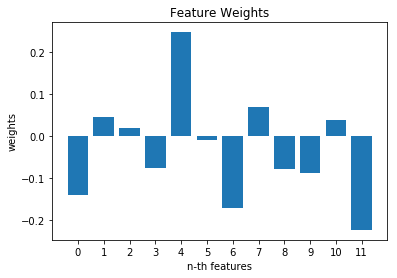

In [7]:
plt.figure("Weights")
plt.bar(range(len(min_weights)-1), min_weights[1:]) #plot weights, excluding bias weight (w0)

plt.xticks(range(len(min_weights)-1))
plt.title("Feature Weights")
plt.ylabel("weights")
plt.xlabel("n-th features")

plt.show()

From the bar plot above, it is clear that 4-th feature has the most weight.  
*2-th feature is the least dominant.

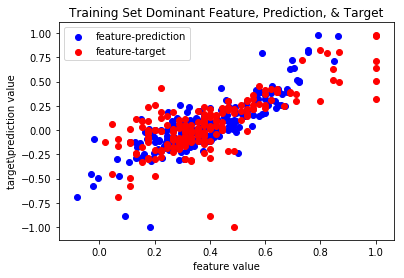

In [8]:
most_dom_feat = 4
least_dom_feat = 1

plt.figure(1)

n = range(len(train_feature[:,most_dom_feat])) #number of datapoints

plt.scatter(regFunction(train_feature, min_weights), 
            train_feature[:,most_dom_feat], color='b', label="feature-prediction")
plt.scatter(train_target, 
            train_feature[:,most_dom_feat], color='r', label="feature-target")

plt.title("Training Set Dominant Feature, Prediction, & Target")
plt.ylabel("target\prediction value")
plt.xlabel("feature value")

plt.legend()
plt.show()

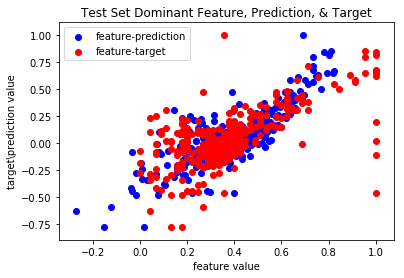

In [14]:
plt.figure(2)

n = range(len(test_feature[:,most_dom_feat])) #number of datapoints

plt.scatter(regFunction(test_feature, min_weights), 
            test_feature[:,most_dom_feat], color='b', label="feature-prediction")
plt.scatter(test_target, 
            test_feature[:,most_dom_feat], color='r', label="feature-target")

plt.title("Test Set Dominant Feature, Prediction, & Target")
plt.ylabel("target\prediction value")
plt.xlabel("feature value")

plt.legend()
plt.show()

## Regression with regularisation

Implement a function to find the maximum likelihood solution $w_{reg}$ for some regularisation parameter $\lambda > 0$.

In [41]:
def maxLikelihood_regularized(X, t, lamb):
    # add a bias column to feature matrix (i.e column of 1s)
    Xb = np.ones((X.shape[0], X.shape[1]+1))
    Xb[:, 1:] = X
    X = Xb
    
    I = np.diag(np.ones((X.shape[1]))) #(d*d) identity matrix
    
    print(X.T@X + lamb*I)
    
    return inv(X.T@X + lamb*I) @ X.T @ t

def RMSE_regularized(X, t, lamb, w):
    # add a bias column to feature matrix (i.e column of 1s)
    Xb = np.ones((X.shape[0], X.shape[1]+1))
    Xb[:, 1:] = X
    X = Xb
    
    I = np.diag(np.ones((X.shape[1]))) #(d*d) identity matrix
    
    return 1/X.shape[0] * ( (X@w-t)@(X@w-t) + lamb*(w@w) )

By calculating the RMSE on the training and test sets, evaluate the impact of regularisation for $\lambda = 1.1$.

What is the effect of regularisation?

### <span style="color:blue">Answer</span>

Regularization prevents overfitting from high model complexity, as $\frac{\lambda}{2}||w||_{2}^{2}$ term in the error function increases error from having more weights (which implies more complex model).

In [2]:
lamb = 2.0 #lagrangian multiplier

minw = maxLikelihood_regularized(train_feature, train_target, lamb)
print("Regularized Error-Minimizing weights:")
print(minw)

print("Regularized RMSE (training):")
print(RMSE_regularized(train_feature, train_target, lamb, minw))

print("Regularized RMSE (test):")
print(RMSE_regularized(test_feature, test_target, lamb, minw))

NameError: name 'maxLikelihood_regularized' is not defined

## Picking a regularisation parameter

You will now explore picking a good regularisation parameter.

What would you expect to see if you were under-regularising (so the parameter was too small)? Over-regularising? Discuss with a partner.

Plot the RMSE on the training and test sets against the regularisation parameter $\lambda$ for a range of values of $\lambda$. What is a good range of values of $\lambda$ to check? What do you think is the best value?

Hint: You may find you want to plot against $\log(\lambda)$. The functions ``np.arange`` and ``np.linspace`` could be useful here (use whichever you think is more applicable).

### <span style="color:blue">Answer</span>
<i>--- replace this with your solution, add and remove code and markdown cells as appropriate ---</i>

In [1]:
lambs = np.arange(start=0.2,stop=20.0,step=0.2)
test_errors = np.empty(len(lambs))
train_errors = np.empty(len(lambs))

for i in range(len(lags)):    
    min_weight = maxLikelihood_regularized(train_feature, train_target, lambs[i])
    test_errors[i] = RMSE_regularized(test_feature, test_target, lambs[i], min_weight)
    train_errors[i] = RMSE_regularized(train_feature, train_target, lambs[i], min_weight)

    
plt.figure(3)
plt.plot(lambs, test_errors, color='b', label="test set")
plt.plot(lags, train_errors, color='r', label="training set")

plt.title("RMSE - $\lambda$ comparison")
plt.xlabel("$\lambda$")
plt.ylabel("RMS Error")

plt.legend()
plt.show()



NameError: name 'np' is not defined

# Basis Functions
We want to use basis functions to improve our performance. Implement subroutines for polynomial basis function of degree 2. See [the feature map based on the binomial formula](http://en.wikipedia.org/wiki/Polynomial_kernel) .

In [49]:
def basis_function(X, d):
    Xp = np.empty((X.shape[0], X.shape[1]**d))
    Xp[:,:X.shape[1]] = X
    for i in range(X.shape[1]):
        for j in range(i,X.shape[1]):
            xn = X[:,i] * X[:,j]
            Xp[:,X.shape[1]+i] = xn
    return Xp

a = np.ones((4,2))

polyX_train = basis_function(a, 2)
print(polyX_train)
# polyX_test = basis_function(test_feature, 2)
# print(train_feature.shape)
# print(polyX)
# print(polyX.shape)

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]


Apply this to your train and test sets, and repeat the above exercise with these new features. Report what differences you see.

### <span style="color:blue">Answer</span>
<i>--- replace this with your solution, add and remove code and markdown cells as appropriate ---</i>

In [42]:
maxLikelihood_regularized(polyX_train, train_target, 1.1)


[[ 2.03100000e+002 -1.89181314e+002 -1.52880000e+002 ...  1.55023933e+294
               nan  4.61191211e+289]
 [-1.89181314e+002  1.81250026e+002  1.40149157e+002 ... -1.54868752e+294
               nan -4.60867173e+289]
 [-1.52880000e+002  1.40149157e+002  1.62452200e+002 ... -1.55023032e+294
               nan  3.55125185e+288]
 ...
 [ 1.55023933e+294 -1.54868752e+294 -1.55023032e+294 ...              inf
               nan              nan]
 [             nan              nan              nan ...              nan
               nan              nan]
 [ 4.61191211e+289 -4.60867173e+289  3.55125185e+288 ...              nan
               nan              inf]]


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])